In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import make_joint, plot_joint, plot_contour, normalize

In [3]:
x = [1, 3, 5]
y = [2, 4]
# np.meshgrid() 함수를 통해 grid 형성
# X * Y가 x와 y의 Tensor product
X, Y = np.meshgrid(x, y)
X, Y, X * Y

(array([[1, 3, 5],
        [1, 3, 5]]),
 array([[2, 2, 2],
        [4, 4, 4]]),
 array([[ 2,  6, 10],
        [ 4, 12, 20]]))

In [4]:
# 데이터프레임에 넣어서 이해를 쉽게
df = pd.DataFrame(X * Y, columns=x, index=y)
df

,1,3,5
2,2,6,10
4,4,12,20


<AxesSubplot:>

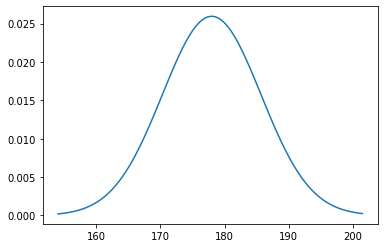

In [5]:
mean = 178
std = 7.7
qs = np.arange(mean - 24, mean + 24, 0.5)
ps = ss.norm(mean, std).pdf(qs)
prior = Pmf(ps, qs)
prior.normalize()
prior.plot()

1.0

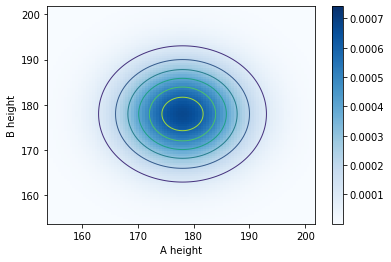

In [8]:
joint = make_joint(prior, prior)
plot_joint(joint)
plot_contour(joint)
joint.sum().sum()

In [19]:
x = joint.columns
y = joint.index
X, Y = np.meshgrid(x, y)
# 책에서는 np.where 활용했는데, astype() 메서드로 가볍게 처리 가능
A_taller = (X > Y).astype('int')
# x가 index인 이유 → 사실 x나 y가 어떠한게 index여도 상관없음. 둘이 같기 때문
likelihood = pd.DataFrame(A_taller, index=y, columns=x)
likelihood

,154.0,154.5,155.0,155.5,156.0,156.5,157.0,157.5,158.0,158.5,...,197.0,197.5,198.0,198.5,199.0,199.5,200.0,200.5,201.0,201.5
154.0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
154.5,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
155.0,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
155.5,0,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
156.0,0,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
200.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
200.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
201.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


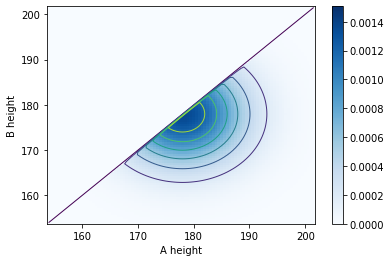

In [22]:
posterior = joint * likelihood
normalize(posterior)
plot_joint(posterior)
plot_contour(posterior)

In [26]:
column = posterior.loc[:, 180]
column

154.0    0.000010
154.5    0.000013
155.0    0.000015
155.5    0.000019
156.0    0.000022
           ...   
199.5    0.000000
200.0    0.000000
200.5    0.000000
201.0    0.000000
201.5    0.000000
Name: 180.0, Length: 96, dtype: float64

In [32]:
Pmf(posterior.stack())

154.0  154.0    0.000000e+00
       154.5    1.012260e-07
       155.0    1.231528e-07
       155.5    1.491988e-07
       156.0    1.799928e-07
                    ...     
201.5  199.5    0.000000e+00
       200.0    0.000000e+00
       200.5    0.000000e+00
       201.0    0.000000e+00
       201.5    0.000000e+00
Name: , Length: 9216, dtype: float64

In [33]:
# 새로 함수를 만드는 대신 Pmf 및 stack 이용하여 원래 있는 메서드 활용
marginal_A = Pmf(posterior.stack()).marginal(1)
marginal_B = Pmf(posterior.stack()).marginal(0)

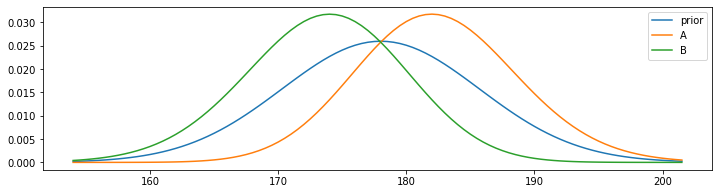

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
prior.plot(ax=ax, label='prior')
marginal_A.plot(ax=ax, label='A')
marginal_B.plot(ax=ax, label='B')
plt.legend()
plt.show()

In [35]:
prior.mean(), marginal_A.mean(), marginal_B.mean()

(177.99516026921506, 182.38728123421686, 173.6028600023339)

In [36]:
marginal_A.credible_interval(0.9), marginal_B.credible_interval(0.9)

(array([172.5, 193. ]), array([163. , 183.5]))

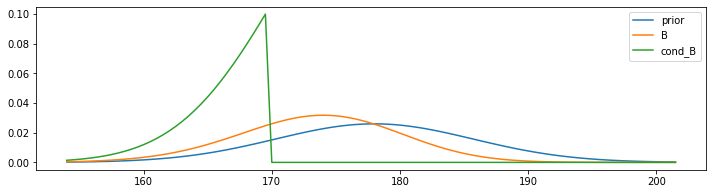

In [37]:
column_170 = posterior.loc[:, 170]
cond_B = Pmf(column_170)
cond_B.normalize()
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
prior.plot(ax=ax, label='prior')
marginal_B.plot(ax=ax, label='B')
cond_B.plot(ax=ax, label='cond_B')
plt.legend()
plt.show()